# Random Forest CV

## Preprocess Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath('../'))

from Models.RandomForestRegressor import RandomForestRegressor
from Utils.Preprocessor import Preprocessor
from Utils.Utils import root_mean_squared_error, train_test_split, initial_preprocessing, feature_elimination
from Utils.CrossValidation import KFoldCrossValidation
from Utils.Pipeline import Pipeline

In [2]:
# Read the data
train = pd.read_csv('../Data/train.csv', index_col='Id')
# Remove unnecessary features based on exploratory data analysis part 1.
train = initial_preprocessing(train)
train = feature_elimination(train)
X = train.drop(columns=["num_wins_agent1", "num_draws_agent1", "num_losses_agent1", "utility_agent1"], axis=1)
y = train["utility_agent1"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# clip the dataset
X_train = X_train[0:10000]
y_train = y_train[0:10000]

## Randomized CV

In [4]:
# Randomized Cross Validation
num_folds = 4
num_iterations = 6

# uniform max_depth range
n_estimators_range = np.arange(100, 500, 10)
max_depth_range = np.arange(4, 10)
min_samples_split_percentage_range = np.linspace(0.01, 0.1, 10)
results = []

for i in range(num_iterations):
    n_estimators = 30
    max_depth = np.random.choice(max_depth_range).astype(int)
    min_samples_split_percentage = np.random.choice(min_samples_split_percentage_range)
    min_samples = int(X_train.shape[0] * min_samples_split_percentage)
    pipeline = Pipeline(Preprocessor(normalize=True, standardize=False, one_hot_encode=True), RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples))
    print(f"Iteration {i+1} / {num_iterations} - n_estimators: {n_estimators} Max Depth: {max_depth}, Min Samples: {min_samples}")

    cross_val = KFoldCrossValidation(pipeline, X_train, y_train, num_folds)
    mean_score = cross_val.mean_score()
    results.append(([n_estimators, max_depth, min_samples_split_percentage], mean_score))

    print(f"Finished iteration {i + 1}/{num_iterations}, score: {mean_score:.6f}")
    print()
sorted_results = sorted(results, key=lambda x: x[1])

print("Parameters | Score")
print("-" * 25)
for parameter, score in sorted_results:
    print(f"{parameter} | {score:.6f}")

best_params, best_score = sorted_results[0]
print(f"\nBest Params: {best_params}")
print(f"Best Score: {best_score:.6f}")

Iteration 1 / 6 - n_estimators: 30 Max Depth: 9, Min Samples: 100
Finished iteration 1/6, score: 0.502321

Iteration 2 / 6 - n_estimators: 30 Max Depth: 8, Min Samples: 900
Finished iteration 2/6, score: 0.557679

Iteration 3 / 6 - n_estimators: 30 Max Depth: 9, Min Samples: 300
Finished iteration 3/6, score: 0.524528

Iteration 4 / 6 - n_estimators: 30 Max Depth: 8, Min Samples: 500
Finished iteration 4/6, score: 0.541224

Iteration 5 / 6 - n_estimators: 30 Max Depth: 9, Min Samples: 300
Finished iteration 5/6, score: 0.530612

Iteration 6 / 6 - n_estimators: 30 Max Depth: 7, Min Samples: 300
Finished iteration 6/6, score: 0.534566

Parameters | Score
-------------------------
[30, np.int64(9), np.float64(0.01)] | 0.502321
[30, np.int64(9), np.float64(0.030000000000000006)] | 0.524528
[30, np.int64(9), np.float64(0.030000000000000006)] | 0.530612
[30, np.int64(7), np.float64(0.030000000000000006)] | 0.534566
[30, np.int64(8), np.float64(0.05000000000000001)] | 0.541224
[30, np.int64(8

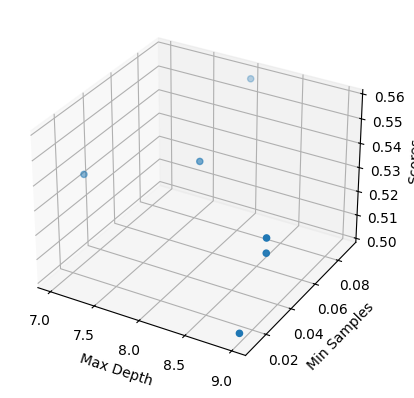

In [8]:
# plot results
max_depth = [x[1] for x, _ in results]
min_samples = [x[2] for x, _ in results]
scores = [score for _, score in results]

# max_depth, min_sample, scores plot for n_estimators = 30
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(max_depth, min_samples, scores)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Min Samples')
ax.set_zlabel('Scores')
# label best params
plt.show()